In [2]:
import time
import datetime as dt
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM
#from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datalab.bigquery as bq
import pandas as pd
import numpy as np
import collections
import math
import shutil
import seaborn


In [7]:
fname = "sppdamec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
#read_csv index_col=0, skiprows=1
#
mdf = pd.DataFrame(mec)
mdf['Hour'] = mdf['Hour'].str.lstrip('HE')
mdf = mdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
print(mdf.head())

      Date Hour      mec
0  8012016   01  28.9543
2  8012016   02  28.1353
1  8012016   03  23.0198
4  8012016   04  20.2738
3  8012016   05  19.6931


In [8]:
fname = "spprtmec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
rdf = pd.DataFrame(mec)
rdf['Hour'] = rdf['Hour'].str.lstrip('HE')
rdf = rdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
#for below need to set indexes first and also name columns based on mkt type too
#pd.merge(mdf,rdf, how='outer', left_index=True, right_index=True)
#can use column instead of index too, left_on=col right_on=[col1,col2] ...
mdf['rtmec'] = rdf['mec']
mdf['diffmec'] = mdf['mec']-mdf['rtmec']
mdf.rename(columns={'mec': 'damec'}, inplace=True)
mdf.describe()

,Date,damec,rtmec,diffmec
count,5.094000e+03,5094.000000,5094.000000,5094.000000
mean,1.411311e+07,24.783158,23.726857,1.056301
std,5.264568e+06,9.168643,18.591004,16.526046
min,8.012016e+06,2.785700,-18.205000,-345.784700
25%,9.232016e+06,18.317450,16.897750,0.062250
50%,1.115202e+07,23.148600,20.407400,2.613550
75%,2.017011e+07,30.184475,26.367925,5.901825
max,2.017030e+07,131.898900,380.685800,110.639400


In [66]:
#get wind 
fname = 'sppwind.csv'
coln = ['interval','windforecast']
wind = pd.read_csv(fname, names=coln)
#get mtlf
fname = 'sppmtlf.csv'
coln = ['interval','loadforecast']
mtlf = pd.read_csv(fname, names=coln)
#get gas price
fname = 'ngprices.csv'
coln = ['interval','ngprice']
gas = pd.read_csv(fname, names=coln)

wind['interval'] = pd.to_datetime(wind['interval'])
wind['date'] = wind['interval'].apply(lambda df : pd.datetime(year=df.year, month=df.month, day=df.day))
mtlf['interval'] = pd.to_datetime(mtlf['interval'])
mtlf['date'] = mtlf['interval'].apply(lambda df : pd.datetime(year=df.year, month=df.month, day=df.day))
gas['interval'] = pd.to_datetime(gas['interval'])
gas.rename(columns={'interval': 'date'}, inplace=True)
gas = gas.sort_values(['date'])
wind = wind.sort_values(['interval'])
mtlf = mtlf.sort_values(['interval'])


gas.head()

,date,ngprice
0,2016-08-01,2.97
1,2016-08-02,2.79
2,2016-08-03,2.89
3,2016-08-04,2.89
4,2016-08-05,2.88


In [82]:
st = gas['date'].iloc[0]
en = gas['date'].iloc[len(gas)-1]

lastprice = 0

for day in pd.date_range(st,en,freq='D'):
  #print( any(gas.date == day))
  if any(gas.date == day):
    lastprice = list(gas[gas['date']==day]['ngprice'])[0]
  else:
    #gas.loc[day]
    gg = pd.DataFrame([[day,lastprice]], columns=['date','ngprice'])
    gas = gas.append(gg, ignore_index=True)
gas = gas.sort_values(['date'])
print gas.tail()

          date  ngprice
168 2017-03-23     2.93
169 2017-03-24     2.97
237 2017-03-25     2.97
238 2017-03-26     2.97
170 2017-03-27     2.94


In [83]:
wind['loadforecast'] = mtlf['loadforecast']
data = pd.merge(wind, gas, on=['date'], how='inner')

data['hour'] = data.interval.apply(lambda x: x.hour)

#data.set_index(['interval'], inplace=True)

print(data.head())
print(data.tail())

             interval  windforecast       date  loadforecast  ngprice  hour
0 2016-08-01 00:00:00       9419.15 2016-08-01         34925     2.97     0
1 2016-08-01 01:00:00       9526.57 2016-08-01         33084     2.97     1
2 2016-08-01 02:00:00       9508.95 2016-08-01         31562     2.97     2
3 2016-08-01 03:00:00       9376.61 2016-08-01         30472     2.97     3
4 2016-08-01 04:00:00       9228.14 2016-08-01         29909     2.97     4
                interval  windforecast       date  loadforecast  ngprice  hour
5683 2017-03-25 19:00:00       2206.26 2017-03-25         25065     2.97    19
5684 2017-03-25 20:00:00       2244.60 2017-03-25         25171     2.97    20
5685 2017-03-25 21:00:00       2717.34 2017-03-25         25756     2.97    21
5686 2017-03-25 22:00:00       3267.67 2017-03-25         25272     2.97    22
5687 2017-03-25 23:00:00       3690.09 2017-03-25         24312     2.97    23


In [84]:
def convDates(row):
  year = ''
  day = ''
  mo = ''
  if (str(row['Date'])[-4:] == '2016'):
    year = str(row['Date'])[-4:]
    day = str(row['Date'])[-6:-4]
    mo = str(row['Date'])[:-6]
  elif (str(row['Date'])[:4] == '2017' or str(row['Date'])[:4] == '2016'):
    year = str(row['Date'])[:4]
    mo = str(row['Date'])[4:6]
    day = str(row['Date'])[6:]

  row['interval'] = year+'-'+mo+'-'+day + ' ' + str(int(row['Hour'])-1)+':00'
  return row

  

In [85]:
mdf = mdf.apply(convDates, axis=1)
mdf['interval'] = pd.to_datetime(mdf['interval'])
mdf.drop('Date', axis=1,inplace=True)
mdf.drop('Hour', axis=1,inplace=True)

KeyError: ('Date', u'occurred at index 0')

In [87]:
data = pd.merge(data, mdf, on=['interval'], how='inner')
data.set_index(['interval'], inplace=True)
data.head()


,windforecast,date,loadforecast,ngprice,hour,damec,rtmec,diffmec
interval,,,,,,,,
2016-08-01 00:00:00,9419.15,2016-08-01,34925,2.97,0,28.9543,23.4502,5.5041
2016-08-01 01:00:00,9526.57,2016-08-01,33084,2.97,1,28.1353,21.5661,6.5692
2016-08-01 02:00:00,9508.95,2016-08-01,31562,2.97,2,23.0198,19.0606,3.9592
2016-08-01 03:00:00,9376.61,2016-08-01,30472,2.97,3,20.2738,17.3855,2.8883
2016-08-01 04:00:00,9228.14,2016-08-01,29909,2.97,4,19.6931,16.4011,3.2920


In [89]:
def updatehour(row):
  row[str(int(row['hour']))] = 1
  return row

In [90]:
tt = data.copy()
tt.drop('date', axis=1,inplace=True)
#tt.drop('hour', axis=1,inplace=True)
tt.drop('damec', axis=1,inplace=True)
tt.drop('rtmec', axis=1,inplace=True)
#pd.tools.plotting.scatter_matrix(tt)

In [91]:
hours = list(set(r for r in tt['hour']))
hours.sort()
print(hours)
for i in range(0,len(hours)):
  tt[str(i)] = pd.Series(np.zeros(len(tt)), index=tt.index)
tt = tt.apply(updatehour, axis=1)
tt.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


,windforecast,loadforecast,ngprice,hour,diffmec,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
interval,,,,,,,,,,,,,,,,,,,,,
2016-08-01 00:00:00,9419.15,34925.0,2.97,0.0,5.5041,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-01 01:00:00,9526.57,33084.0,2.97,1.0,6.5692,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-01 02:00:00,9508.95,31562.0,2.97,2.0,3.9592,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-01 03:00:00,9376.61,30472.0,2.97,3.0,2.8883,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-01 04:00:00,9228.14,29909.0,2.97,4.0,3.2920,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
with open('sppmecdata.csv', 'a') as out:
        out.write( 'interval,hour,windforecast,loadforecast,natgasprice,diffmec,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23\n') 
        for index, row in tt.iterrows():
            out.write(str(row.name) + ',' + str(row['hour']) + ',' + str(row['windforecast']) + ',' + str(row['loadforecast']) + ',' + str(row['ngprice']) + ',' + str(row['diffmec']) + ','
                      + str(row['0']) + ',' 
                      + str(row['1']) + ',' 
                      + str(row['2']) + ',' 
                      + str(row['3']) + ',' 
                      + str(row['4']) + ',' 
                      + str(row['5']) + ',' 
                      + str(row['6']) + ',' 
                      + str(row['7']) + ',' 
                      + str(row['8']) + ',' 
                      + str(row['9']) + ',' 
                      + str(row['10']) + ',' 
                      + str(row['11']) + ',' 
                      + str(row['12']) + ',' 
                      + str(row['13']) + ',' 
                      + str(row['14']) + ',' 
                      + str(row['15']) + ',' 
                      + str(row['16']) + ',' 
                      + str(row['17']) + ',' 
                      + str(row['18']) + ',' 
                      + str(row['19']) + ',' 
                      + str(row['20']) + ',' 
                      + str(row['21']) + ',' 
                      + str(row['22']) + ',' 
                      + str(row['23'])  + '\n') 

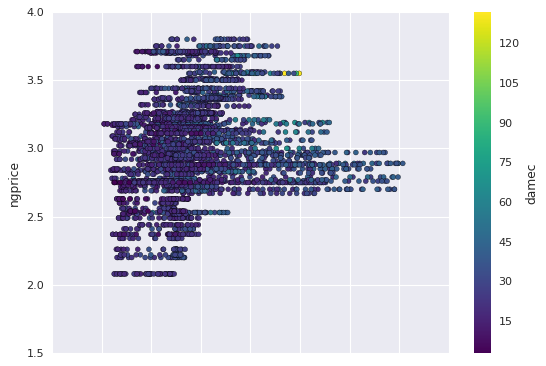

In [26]:
xxs = tt.plot.scatter('loadforecast', 'ngprice', c='damec', colormap='viridis')
#xxs.set_aspect('equal')

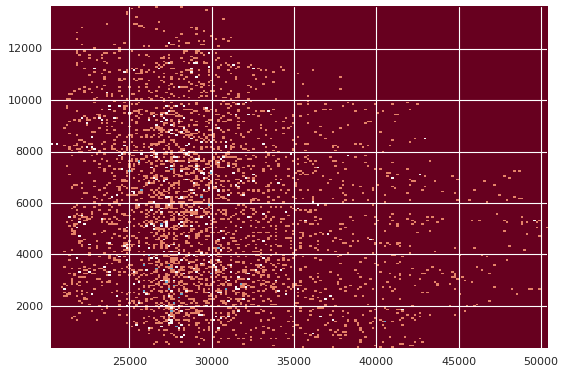

In [20]:
plt.hist2d(tt['loadforecast'],tt['windforecast'], bins=200, cmap=plt.cm.get_cmap('RdBu'))
plt.show()

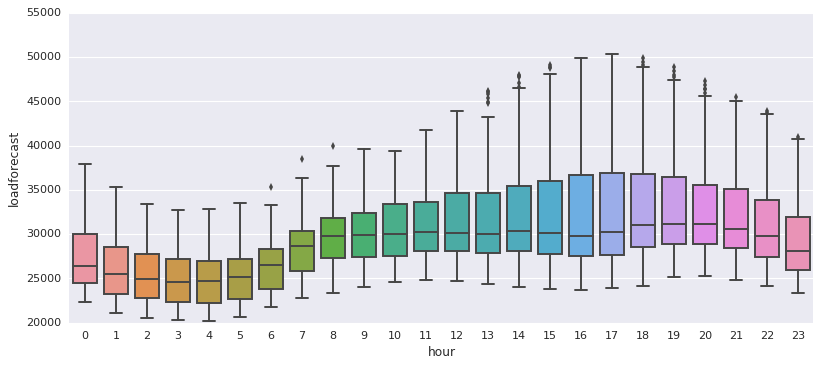

In [40]:
fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(tt['hour'], tt['loadforecast'], ax=ax)

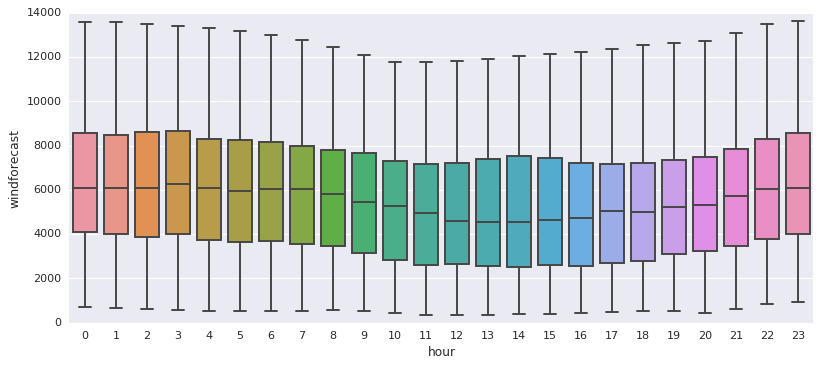

In [43]:
fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(tt['hour'], tt['windforecast'], ax=ax)

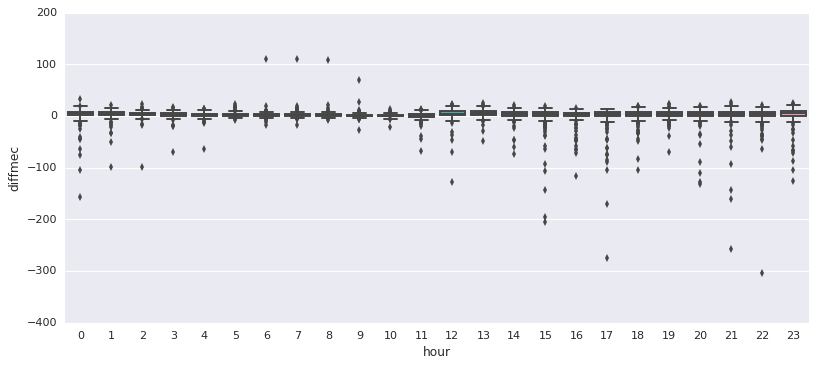

In [42]:
fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(tt['hour'], tt['diffmec'], ax=ax)

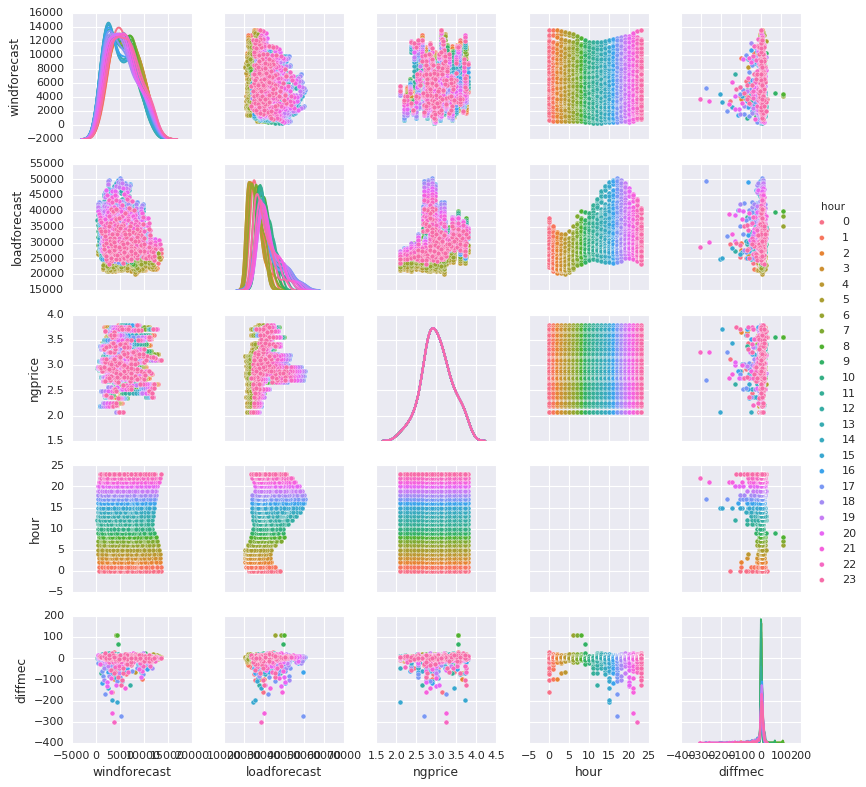

In [12]:
seaborn.pairplot(tt, hue='hour', diag_kind='kde', size=2)

In [10]:
#do linear regression using gradient descent

def gradient_descent_runner(data, initial_b, wf_weight, lf_weight, ng_weight, learning_rate, num_iterations):
  b = initial_b
  w = wf_weight
  l = lf_weight
  n = ng_weight
  
  for i in range(num_iterations):
    b,w,l,n = step_gradient(b,w,l,n, data, learning_rate)
    print "Iteration " + str(i) + " Error: " + str(compute_error_for_given_data(b,w,l,n,data))
  return [b,w,l,n]

def step_gradient(b,w,l,n, data, learning_rate):
  #gradient descent
  #partial derivative
  b_gradient = 0
  w_gradient = 0
  l_gradient = 0
  n_gradient = 0
  Nm = float(len(data))
  
  for i in range(0,len(data)):
    y = data.iloc[i]['diffmec']
    wf = data.iloc[i]['windforecast']
    lf = data.iloc[i]['loadforecast']
    ng = data.iloc[i]['ngprice']
    b_gradient += -(2/Nm) * (y - (w*wf + l*lf + n*ng) + b)
    #w_gradient += -(2/Nm) * wf * (y - (w*wf + l*lf + n*ng + b))
    l_gradient += -(2/Nm) * lf * (y - (w*wf + l*lf + n*ng + b))
    #n_gradient += -(2/Nm) * ng * (y - (w*wf + l*lf + n*ng + b))
  
  new_b = b - (learning_rate*b_gradient)
  #new_w = w - (learning_rate*w_gradient)
  new_l = l - (learning_rate*l_gradient)
  #new_n = n - (learning_rate*n_gradient)
  #return [new_b, new_w, new_l, new_n]
  return [new_b, 0, new_l, 0]
  
def compute_error_for_given_data(b,w,l,n,data):
  #sum of squared error
  totalError = 0
  for i in range(0,len(data)):
    y = data.iloc[i]['diffmec']
    wf = data.iloc[i]['windforecast']
    lf = data.iloc[i]['loadforecast']
    ng = data.iloc[i]['ngprice']
    totalError += (y - (w*wf + l*lf + n*ng + b)) **2
  return totalError/float(len(tt))

In [48]:
len(tt)


3648

In [ ]:
learning_rate = 0.001
num_iterations = 100

initial_b = 0
wf_weight = 0
lf_weight = 0
ng_weight = 0
[b, w, l, n] = gradient_descent_runner(tt, initial_b, wf_weight, lf_weight, ng_weight, learning_rate, num_iterations)
print("FINAL:")
print(b)
print(w)
print(l)
print(n)
print compute_error_for_given_data(b,w,l,n,tt)


Iteration 0 Error: 2.99390599545e+12
Iteration 1 Error: 1.01267690112e+25
Iteration 2 Error: 3.42533969914e+37
Iteration 3 Error: 1.15860765082e+50
Iteration 4 Error: 3.91894470751e+62
Iteration 5 Error: 1.32556759915e+75
